# Setup & Imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Add project root to path to access our package
sys.path.append(os.path.abspath('../../'))

from spatial_fdr_evaluation.data.adbench_loader import load_from_ADbench
from spatial_fdr_evaluation.methods.kernels import compute_kernel_matrix, estimate_length_scale

# Plotting settings
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")
%matplotlib inline

# Data Loading & Preprocessing

In [2]:
def analyze_full_dataset(dataset_name, sigma_factor=1.0):
    """
    Loads full dataset, computes kernel, and checks spectral gap.
    """
    print(f"--- Processing {dataset_name} ---")
    
    # 1. Load & Scale Full Data
    data = load_from_ADbench(dataset_name)
    X_full = data['X_train']
    scaler = StandardScaler()
    X_full = scaler.fit_transform(X_full)
    
    # 2. Compute Global Kernel
    base_sigma = estimate_length_scale(X_full, method='median')
    sigma = base_sigma * sigma_factor
    print(f"  N={len(X_full)}, D={X_full.shape[1]}")
    print(f"  Sigma: {sigma:.4f}")
    
    K_full = compute_kernel_matrix(X_full, kernel_type='rbf', length_scale=sigma)
    
    # 3. Spectral Eigengap (Check for Blocks)
    # Normalized Affinity: D^-1/2 K D^-1/2
    D = np.array(K_full.sum(axis=1)).flatten()
    D[D < 1e-10] = 1e-10
    D_inv_sqrt = np.diag(1.0 / np.sqrt(D))
    A_norm = D_inv_sqrt @ K_full @ D_inv_sqrt
    
    # Get largest eigenvalues (equivalent to smallest Laplacian eigenvalues)
    try:
        evals, evecs = eigsh(A_norm, k=15, which='LA')
    except:
        evals, evecs = linalg.eigh(A_norm)
        evals, evecs = evals[-15:], evecs[:, -15:]
        
    # Sort descending
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    
    # Gap analysis (on Laplacian scale: 1 - lambda)
    gaps = np.diff(1 - evals)
    optimal_k = np.argmax(gaps) + 1
    max_gap = gaps[optimal_k-1]
    
    print(f"  Max Eigengap: {max_gap:.4f} at k={optimal_k}")
    
    return {
        'X': X_full,
        'K': K_full,
        'evecs': evecs,
        'optimal_k': optimal_k,
        'sigma': sigma,
        'max_gap': max_gap
    }

# Run
global_res = analyze_full_dataset('2_annthyroid')

Loading 2_annthyroid...
current noise type: None
{'Samples': 7200, 'Features': 6, 'Anomalies': 534, 'Anomalies Ratio(%)': 7.42}
  Shape: (5040, 6)
  Original Anomaly Rate: 0.7%


# Kernel Construction & Spectral Analysis

Using Length Scale (sigma): 2.4618 (Base: 2.4618)


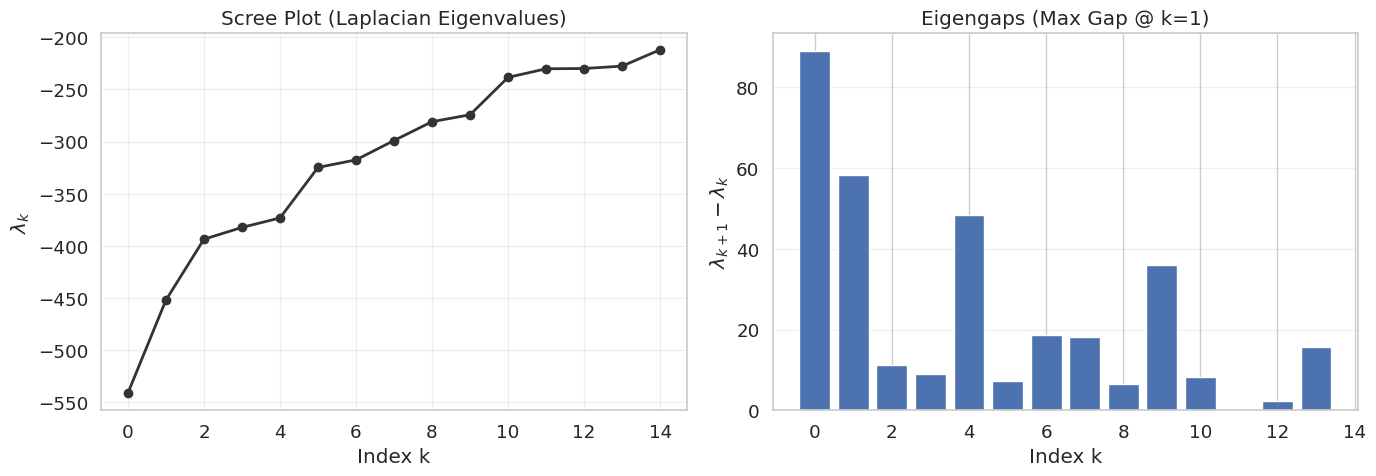

Generating Clustermap...
Subsampling matrix (N=5040) to 2000 points for visualization speed...


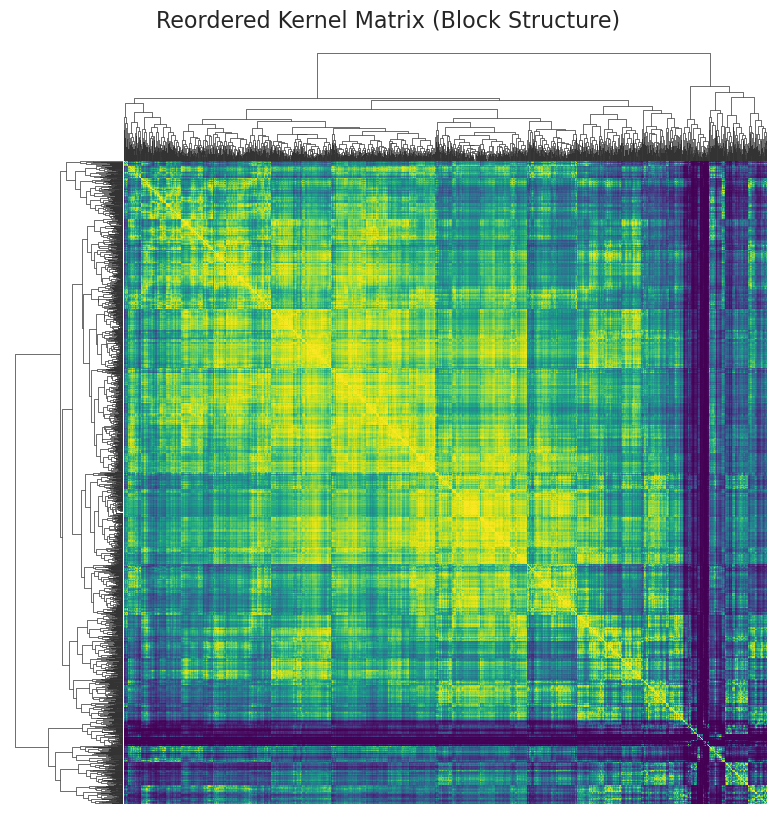

Suggested Number of Blocks: 1 (Gap Strength: 89.1522)


In [9]:
def subsample_experiment(global_res, n_total=500, h1_ratio=0.1):
    """
    1. Defines Signal Region on FULL dataset.
    2. Subsamples to get exact H1/H0 ratio.
    """
    X = global_res['X']
    optimal_k = global_res['optimal_k']
    evecs = global_res['evecs']
    
    # 1. Define Signal Block on Full Data
    # Use spectral embedding to find the 'tightest' block
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels_full = kmeans.fit_predict(evecs[:, :optimal_k])
    
    # Pick a random cluster to be the "Signal Source"
    signal_cluster_id = np.random.randint(optimal_k)
    h1_candidates = np.where(labels_full == signal_cluster_id)[0]
    h0_candidates = np.where(labels_full != signal_cluster_id)[0]
    
    # 2. Subsample
    n_h1 = int(n_total * h1_ratio)
    n_h0 = n_total - n_h1
    
    # Randomly draw required counts
    if len(h1_candidates) < n_h1:
        print(f"Warning: Signal cluster too small ({len(h1_candidates)}), taking all.")
        n_h1 = len(h1_candidates)
        
    idx_h1 = np.random.choice(h1_candidates, n_h1, replace=False)
    idx_h0 = np.random.choice(h0_candidates, n_h0, replace=False)
    
    final_indices = np.concatenate([idx_h1, idx_h0])
    # Shuffle so H1s aren't all at the start
    np.random.shuffle(final_indices)
    
    # 3. Create Final Experiment Set
    X_sub = X[final_indices]
    
    # Recompute K for the subset (Standard practice: Kernel depends on X_sub)
    # Alternatively, slice K_full. Slicing is faster and consistent.
    K_sub = global_res['K'][np.ix_(final_indices, final_indices)]
    
    # Create Labels (0=H1, 1=H0)
    # Note: Using your convention 0=Alt? Or standard 1=Alt? 
    # Let's stick to: 0=H1 (Alternative), 1=H0 (Null) as per your previous code
    true_labels = np.ones(n_total, dtype=int)
    # We need to find where the h1 indices ended up after shuffle
    # Easier way: create label array aligned with final_indices
    is_h1 = np.isin(final_indices, idx_h1)
    true_labels[is_h1] = 0
    
    return {
        'X': X_sub,
        'K': K_sub,
        'true_labels': true_labels,
        'indices': final_indices
    }

experiment = subsample_experiment(global_res, n_total=500, h1_ratio=0.1)

# Conditional Signal Injection (Seed & Grow)

In [4]:
def seed_signal_regions(X, kernel_results, signal_fraction=0.2, min_gap_threshold=0.01):
    """
    Injects H1 signals ONLY if structure exists, using spectral properties
    to find robust seeds.
    """
    max_gap = kernel_results['max_gap']
    optimal_k = kernel_results['optimal_k']

    # 1. Validation Check
    if max_gap < min_gap_threshold:
        print(f"WARNING: Weak spatial structure (Gap {max_gap:.4f} < {min_gap_threshold}).")
        print("Data is effectively a single blob. Signal injection will be arbitrary.")
        # Fallback: Random seed
        seed_indices = np.random.choice(len(X), size=1, replace=False)
    else:
        print(f"Valid structure found. Using Spectral Embedding (k={optimal_k}) to pick seeds.")

        # 2. Spectral Clustering to find block centers
        # Use top k eigenvectors for embedding
        embedding = kernel_results['eigenvecs'][:, :optimal_k]
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10).fit(embedding)

        # Pick one cluster to be the "Signal Block"
        signal_cluster_id = np.random.randint(optimal_k)
        cluster_indices = np.where(kmeans.labels_ == signal_cluster_id)[0]

        # 3. Find the "Medoid" of this cluster (Max Kernel Density within cluster)
        # This gives us the geometric center of the block
        K_sub = kernel_results['K'][np.ix_(cluster_indices, cluster_indices)]
        density_scores = K_sub.sum(axis=1)
        local_best_idx = np.argmax(density_scores)
        seed_idx = cluster_indices[local_best_idx]
        seed_indices = [seed_idx]

    # 4. Grow Region
    # Select N points with highest kernel similarity to the seed(s)
    K = kernel_results['K']

    # Sum of similarities to all seeds (if multiple)
    similarity_to_seeds = np.sum(K[:, seed_indices], axis=1)

    # Select top fraction as H1
    n_h1 = int(len(X) * signal_fraction)
    # argsort is ascending, so take last n_h1
    h1_indices = np.argsort(similarity_to_seeds)[-n_h1:]

    # Create Labels (1=Null, 0=Alternative)
    true_labels = np.ones(len(X), dtype=int)
    true_labels[h1_indices] = 0

    return true_labels, h1_indices

true_labels, h1_indices = seed_signal_regions(X, results)
print(f"Generated {len(h1_indices)} H1 hypotheses.")

Valid structure found. Using Spectral Embedding (k=1) to pick seeds.
Generated 1008 H1 hypotheses.


# P-value Simulation

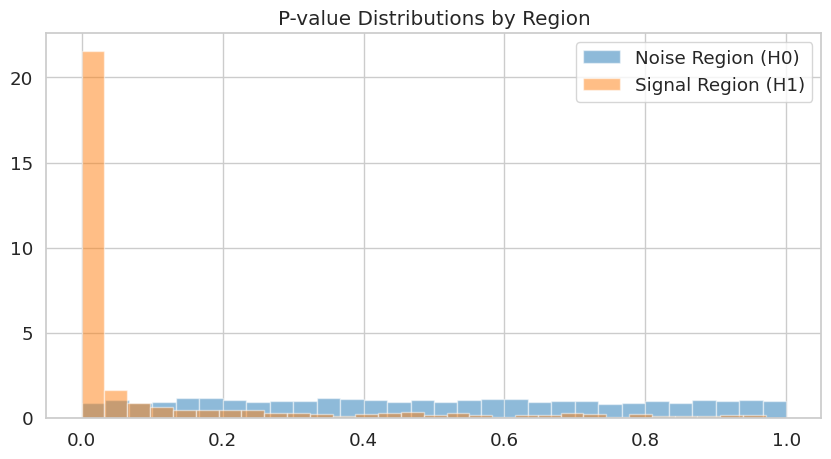

In [5]:
def generate_pvalues(true_labels, effect_strength='medium'):
    """
    Simulates p-values.
    H0: Uniform(0,1)
    H1: Beta(alpha, 1)
    """
    n = len(true_labels)
    p_values = np.zeros(n)

    # Signal strength parameters (lower alpha = stronger signal)
    alphas = {'weak': 0.5, 'medium': 0.1, 'strong': 0.01}
    a = alphas.get(effect_strength, 0.1)

    # Vectorized generation
    h0_mask = (true_labels == 1)
    h1_mask = (true_labels == 0)

    p_values[h0_mask] = np.random.uniform(0, 1, size=h0_mask.sum())
    p_values[h1_mask] = np.random.beta(a, 1, size=h1_mask.sum())

    return p_values

p_values = generate_pvalues(true_labels, effect_strength='medium')

# Diagnostic Plot: Histograms
plt.figure(figsize=(10, 5))
plt.hist(p_values[true_labels==1], bins=30, alpha=0.5, label='Noise Region (H0)', density=True)
plt.hist(p_values[true_labels==0], bins=30, alpha=0.5, label='Signal Region (H1)', density=True)
plt.title("P-value Distributions by Region")
plt.legend()
plt.show()

# The "Oracle View" Diagnostics

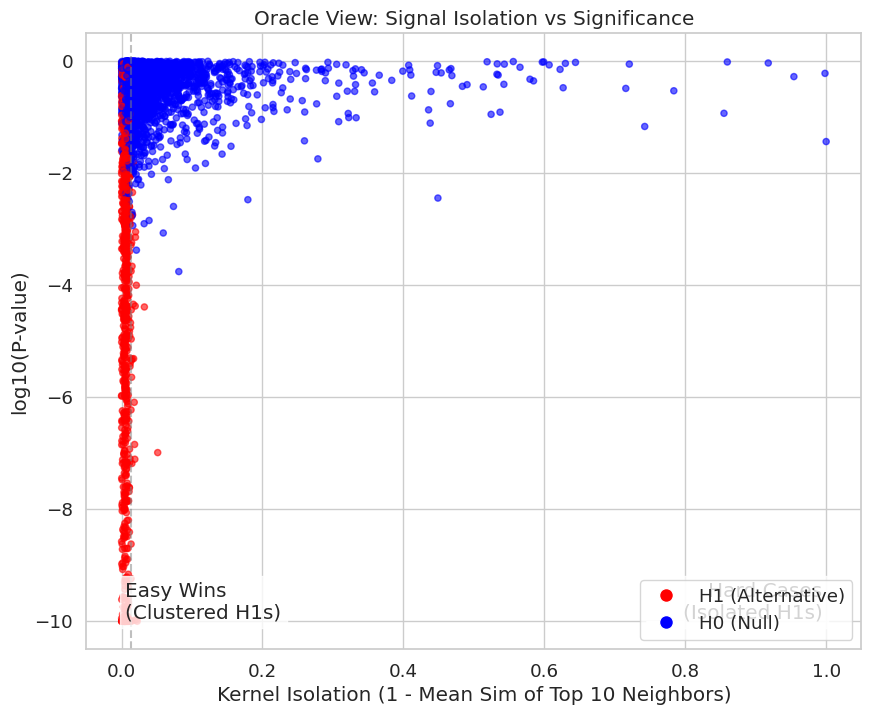

In [6]:
def plot_oracle_view(X, K, true_labels, p_values):
    """
    Visualizes the difficulty of the spatial FDR problem.
    Metrics:
    - Kernel Isolation: How 'lonely' is a point in kernel space?
    """
    # 1. Calculate Isolation Metric
    # Average kernel similarity to nearest 10 neighbors (excluding self)
    # We copy diagonal to 0 to ignore self-similarity
    K_no_diag = K.copy()
    np.fill_diagonal(K_no_diag, 0)

    # Sort each row descending
    sorted_sims = np.sort(K_no_diag, axis=1)[:, ::-1]

    # Mean similarity of top 10 neighbors
    avg_sim_top10 = np.mean(sorted_sims[:, :10], axis=1)

    # Isolation = 1 - Similarity (High val = Isolated)
    isolation_score = 1 - avg_sim_top10

    # 2. Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Color mapping
    colors = np.where(true_labels==0, 'red', 'blue')
    labels = np.where(true_labels==0, 'H1 (Alternative)', 'H0 (Null)')

    scatter = ax.scatter(isolation_score, np.log10(p_values + 1e-10),
                         c=colors, alpha=0.6, s=20)

    # Formatting
    ax.set_xlabel("Kernel Isolation (1 - Mean Sim of Top 10 Neighbors)")
    ax.set_ylabel("log10(P-value)")
    ax.set_title("Oracle View: Signal Isolation vs Significance")

    # Custom Legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10),
                    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10)]
    ax.legend(custom_lines, ['H1 (Alternative)', 'H0 (Null)'])

    # Add quadrant annotation
    ax.axvline(x=np.median(isolation_score), color='gray', linestyle='--', alpha=0.5)
    ax.text(0.05, 0.05, "Easy Wins\n(Clustered H1s)", transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8))
    ax.text(0.95, 0.05, "Hard Cases\n(Isolated H1s)", transform=ax.transAxes, ha='right',
            bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

plot_oracle_view(X, results['K'], true_labels, p_values)

# Multi-Dataset Summary Loop

In [7]:
dataset_list = ['2_annthyroid', '23_mammography', '40_vowels'] # Add more from ADbench
summary_stats = []

print(f"{'Dataset':<20} | {'N':<6} | {'Dims':<4} | {'Gap':<8} | {'Blocks':<6} | {'Sigma':<6}")
print("-" * 65)

for name in dataset_list:
    try:
        # Load
        data = load_from_ADbench(name)
        X_raw = data['X_train']
        scaler = StandardScaler()
        X_curr = scaler.fit_transform(X_raw)

        # Analyze
        res = analyze_kernel_structure(X_curr)

        # Print row
        print(f"{name:<20} | {len(X_curr):<6} | {X_curr.shape[1]:<4} | "
              f"{res['max_gap']:.4f}   | {res['optimal_k']:<6} | {res['sigma']:.2f}")

    except Exception as e:
        print(f"{name:<20} | ERROR: {str(e)}")

print("-" * 65)

Dataset              | N      | Dims | Gap      | Blocks | Sigma 
-----------------------------------------------------------------
current noise type: None
{'Samples': 7200, 'Features': 6, 'Anomalies': 534, 'Anomalies Ratio(%)': 7.42}
Using Length Scale (sigma): 2.4618 (Base: 2.4618)
2_annthyroid         | 5040   | 6    | 75.6977   | 1      | 2.46
subsampling for dataset 23_mammography...
current noise type: None
{'Samples': 10000, 'Features': 6, 'Anomalies': 226, 'Anomalies Ratio(%)': 2.26}
Using Length Scale (sigma): 2.8887 (Base: 2.8887)
23_mammography       | 7000   | 6    | 535.0153   | 1      | 2.89
current noise type: None
{'Samples': 1456, 'Features': 12, 'Anomalies': 50, 'Anomalies Ratio(%)': 3.43}
Using Length Scale (sigma): 4.8337 (Base: 4.8337)
40_vowels            | 1019   | 12   | 33.1720   | 3      | 4.83
-----------------------------------------------------------------
